__Using Statistics to Identify Spam__

*Oscar Padilla*

# Introduction
The R code below was mainly developed in [Chapter 3] (http://rdatasciencecases.org/Spam/code.R) of the book by Deborah Nolan and Duncan Temple Lang called “Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving” [1]. 
This original code was modified, as needed, in order to solve question (19) in the Exercises section.

# Background

In this case study, authors [1] examine over 9000 messages that have been classified by SpamAssassin (http://spamassassin.apache.org) for the purpose of developing and testing spam filters using naive Bayes and decision trees.

__Question 19)__  Consider the other parameters that can be used to control the recursive partitioning process. Read the documentation for them in the rpart.control() documentation. Also, carry out an Internet search for more information on how to tweak the rpart() tuning parameters. Experiment with values for these parameters. Do the trees that result make sense with your understanding of how the parameters are used? Can you improve the prediction using them?

# Methods

In this section, the data frame `emailDFrp` developed in Section 3.11 (Fitting the rpart() Model to the email Data - by Nolan & Lang) is loaded in order to start experimenting with `rpart`. 

The decision tree developed in the same section is replicated (i.e. Base Model) and will be compared against an Optimized Model developed in later sections.


## Importing Data Frame from Chapter 3

In [24]:
load('Data/emailDFrp')

In [25]:
head(emailDFrp)

,isSpam,isRe,underscore,priority,isInReplyTo,sortedRec,subPunc,multipartText,hasImages,isPGPsigned,⋯,subQuesCt,numAtt,numRec,perCaps,hour,perHTML,subBlanks,forwards,avgWordLen,numDlr
./Data/easy_ham1,Valid,T,F,F,T,T,F,F,F,F,⋯,0,0,2,4.451039,11,0,12.50000,0.000000,4.376623,3
./Data/easy_ham2,Valid,F,F,F,F,T,F,F,F,F,⋯,0,0,1,7.491289,11,0,8.00000,0.000000,4.555556,0
./Data/easy_ham3,Valid,F,F,F,F,T,F,F,F,F,⋯,0,0,1,7.436096,12,0,8.00000,0.000000,4.817164,0
./Data/easy_ham4,Valid,F,F,F,F,T,F,F,F,F,⋯,0,0,0,5.090909,13,0,18.91892,3.125000,4.714286,0
./Data/easy_ham5,Valid,T,F,F,F,T,F,F,F,F,⋯,0,0,1,6.116643,13,0,15.21739,6.451613,4.234940,0
./Data/easy_ham6,Valid,T,F,F,T,T,F,F,F,F,⋯,0,0,1,7.625272,13,0,15.21739,12.000000,3.956897,0


In [26]:
dim(emailDFrp)

[1] 9348   30

<img src = Table_3_1.png>

__Table 1.__ This table provides several possible variables that can be derived from an email message and used for classifying spam [1]

In Chapter 3, 29 logical and numeric variables were developed plus the response variable *Y = isSpam = Valid or Spam*.

In [27]:
library(rpart)

## Training and Test Sets Split

As in Section 3.11, indices are generated for the test set as follows:

In [28]:
set.seed(418910)

spam <- emailDFrp$isSpam == "Spam"
numSpam <- sum(spam)
numHam <- sum(!spam)

testSpamIdx <- sample(numSpam, size = floor(numSpam/3))
testHamIdx <- sample(numHam, size = floor(numHam/3))

In [29]:
testDF <- 
  rbind( emailDFrp[emailDFrp$isSpam == "Spam", ][testSpamIdx, ],
         emailDFrp[emailDFrp$isSpam == "Valid", ][testHamIdx, ])

trainDF <-
  rbind( emailDFrp[emailDFrp$isSpam == "Spam", ][-testSpamIdx, ], 
         emailDFrp[emailDFrp$isSpam == "Valid", ][-testHamIdx, ])

## Fitting the `rpart()` Model to the email Data

In [30]:
rpartFit = rpart(isSpam ~ ., data = trainDF, method = "class")

Fitted tree is plotted with,

In [31]:
library(rpart.plot)
#prp(rpartFit, extra = 1)

__Figure 1.__ Base Model Tree

Let's look at some of the default `rpart` argument used in the Base Model, as described in `rpart.control` documentation [3]:

* __minsplit:__ the minimum number of observations that must exist in a node in order for a split to be attempted (default = 20)

* __cp:__ complexity parameter (ranges from 0 to 1). Any split that does not decrease the overall lack of fit by a factor of `cp` is not attempted. For instance, with `anova` splitting, this means that the overall R-squared must increase by `cp` at each step. The main role of this parameter is to save computing time by pruning off splits that are obviously not worthwhile. Essentially,the user informs the program that any split which does not improve the fit by `cp` will likely be pruned off by cross-validation, and that hence the program need not pursue it

* __maxdepth:__ Set the maximum depth of any node of the final tree, with the root node counted as depth 0. Values greater than 30 rpart will give nonsense results on 32-bit machines (default = 30)

In [32]:
args(rpart.control)

function (minsplit = 20L, minbucket = round(minsplit/3), cp = 0.01, 
    maxcompete = 4L, maxsurrogate = 5L, usesurrogate = 2L, xval = 10L, 
    surrogatestyle = 0L, maxdepth = 30L, ...) 
NULL

## Base Model Confusion Matrix

`mlr` library is used in order to generate the confusion matrix,

In [33]:
library(mlr)

In [34]:
spam.tsk = makeClassifTask(id = "spam", 
                           data = trainDF, 
                           target = "isSpam")

Learner

In [35]:
spam.lrn = makeLearner(cl = "classif.rpart", id ="spam", fix.factors.prediction = TRUE, predict.type = 'prob')

In [36]:
spam.clf <- mlr::train(spam.lrn, spam.tsk)
splits <- getLearnerModel(spam.clf)

Confusion Matrix with AUC, MMCE, FPR, and FNR:

In [37]:
spam.preds <- predict(spam.clf, newdata =  testDF)

preds <- as.data.frame(spam.preds$data)

calculateConfusionMatrix(spam.preds)

performance(spam.preds, measures=list(auc, mmce, fpr, fnr))

        predicted
true     Spam Valid -err.-
  Spam    678   121    121
  Valid   125  2192    125
  -err.-  125   121    246

auc       mmce        fpr        fnr 
0.94418060 0.07894737 0.05394907 0.15143930

# Results

## Optimized Model

The grid search method is used in conjunction with ten-fold stratified cross-validation in order to optimize the model. 

A false positive (i.e. valid email classified as spam) is more costly than a false negative.

## Parameter Search Criteria

* __cp:__ 0.001, 0.01, 0.1, 0.2, 0.5,

* __minsplit:__ 1, 5, 10, 15, 20, 30

* __maxdepth:__ 1, 5, 10, 15, 20, 30

* __splitting criterion:__ gini | information

Resampling binary:

In [38]:
spam.resamp = makeResampleDesc(method = "CV", 
                               iters = 10, 
                               stratify = TRUE)

In [39]:
spam.resamp.bin = makeResampleInstance(spam.resamp, task=spam.tsk)
save(spam.resamp.bin, file = "resampling_binary") # to improve performance later on

In [40]:
load("resampling_binary")

In [41]:
spam.ps = makeParamSet(
                  makeDiscreteParam("cp", values = c(0.001, 0.01, 0.1, 0.2)),
                  makeDiscreteParam("minsplit", values = c(1, 5, 10, 15, 20, 30)),
                  makeDiscreteParam("maxdepth", values = c(1, 5, 10, 15, 20, 30)),
                  makeDiscreteParam("parms", values = list(gini = list(split = c("gini")), 
                                                           info = list(split = c("information"))))
                 )

Create the grid, run parallel multicore and optimize AUC

In [42]:
spam.ctrl = makeTuneControlGrid() 

parallelStart(mode = "multicore", cpus=4)

spam.tuned.clf = tuneParams( learner=spam.lrn, 
                             task=spam.tsk, 
                             resampling=spam.resamp.bin,
                             control=spam.ctrl, 
                             par.set=spam.ps, 
                             measures=list(auc, fpr, fnr, mmce))
parallelStop()

save(spam.tuned.clf, file = 'spam.tuned.clf') # save again for performance

Starting parallelization in mode=multicore with cpus=4.
[Tune] Started tuning learner spam for parameter set:
             Type len Def             Constr Req Tunable Trafo
cp       discrete   -   - 0.001,0.01,0.1,0.2   -    TRUE     -
minsplit discrete   -   -    1,5,10,15,20,30   -    TRUE     -
maxdepth discrete   -   -    1,5,10,15,20,30   -    TRUE     -
parms    discrete   -   -          gini,info   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0Imputation value: 1Imputation value: 1Imputation value: 1
Mapping in parallel: mode = multicore; cpus = 4; elements = 288.
[Tune] Result: cp=0.001; minsplit=20; maxdepth=30; parms=info : auc.test.mean=0.9679128,fpr.test.mean=0.0384133,fnr.test.mean=0.1238954,mmce.test.mean=0.0603341
Stopped parallelization. All cleaned up.


In [43]:
load('spam.tuned.clf')

Get optimal hyper parameters and train the model on training set:

In [44]:
data <- generateHyperParsEffectData(spam.tuned.clf, partial.dep = TRUE)

df_models <- data$data

spam.opt.lrn <- setHyperPars(spam.lrn, par.vals = spam.tuned.clf$x)

spam.opt.clf <- mlr::train(spam.opt.lrn, spam.tsk)

Each combination of parameters is cross-validated on 10 folds of the training data set using AUC as the performance metric. 

Let's plot the hyper parameter effects and their effect on AUC performance after cross-validation:

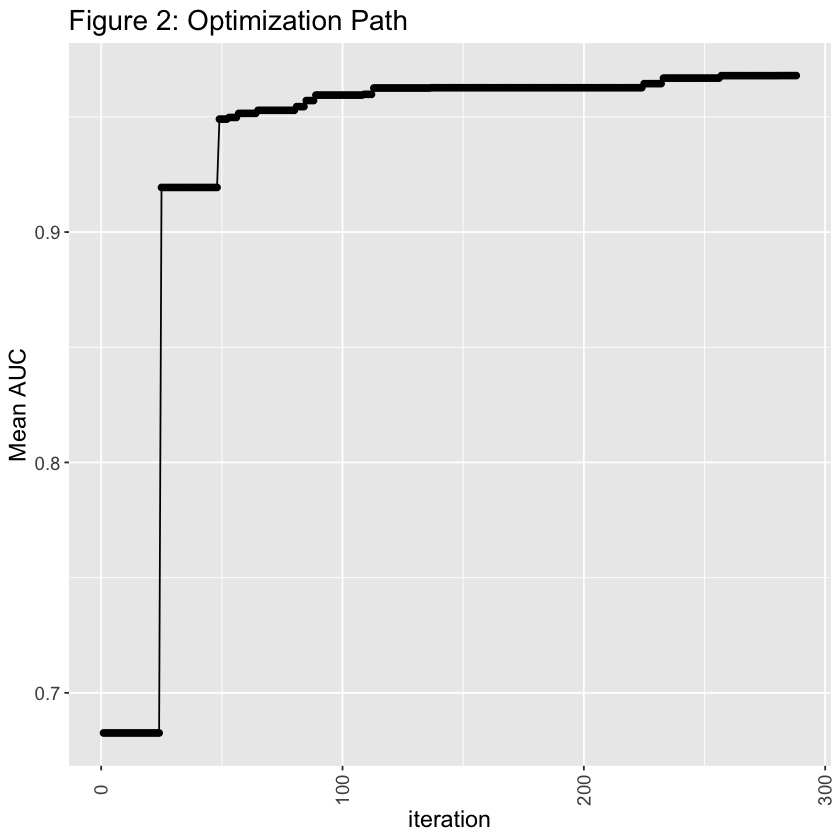

In [45]:
plotHyperParsEffect(data, x = "iteration", y = "auc.test.mean",
  plot.type = "line", partial.dep.learn = "regr.randomForest")+
  ggtitle("Figure 2: Optimization Path")+
  ylab("Mean AUC")+
  theme(legend.position = "bottom", 
        legend.text=element_text(size=8),
        legend.title = element_text(size=10),
        axis.text.x = element_text(angle=90, vjust=0.5),
        text=element_text(size=14))

Let's get the actual `rpart` model,

In [46]:
splits <- getLearnerModel(spam.opt.clf)

## Optimized Model Confusion Matrix

By applying results of tuned model on test set, obtain the performance measures and compare them to the base model

In [47]:
spam.opt.preds <- predict(spam.opt.clf, newdata = testDF)
spam.preds <- predict(spam.clf, newdata =  testDF)

opt <- performance(spam.opt.preds, 
            measures=list(auc, mmce, fpr, fnr))
                
base <- performance(spam.preds, 
            measures=list(auc, mmce, fpr, fnr))

kable(cbind(BaseModel = round(base,3), Optimized = round(opt,3)))



|     | BaseModel| Optimized|
|:----|---------:|---------:|
|auc  |     0.944|     0.972|
|mmce |     0.079|     0.053|
|fpr  |     0.054|     0.032|
|fnr  |     0.151|     0.116|

# Conclusion

As seen on the table above, the Optimized Model outperforms the Base Model on ALL metrics. More importantly as stated earlier, a false positive is more costly than a false negative, and the improvement on the FPR for the optimized model is significant (3.2% vs. 5.4%).

To complement the analysis, the ROC curves are plotted for both models,

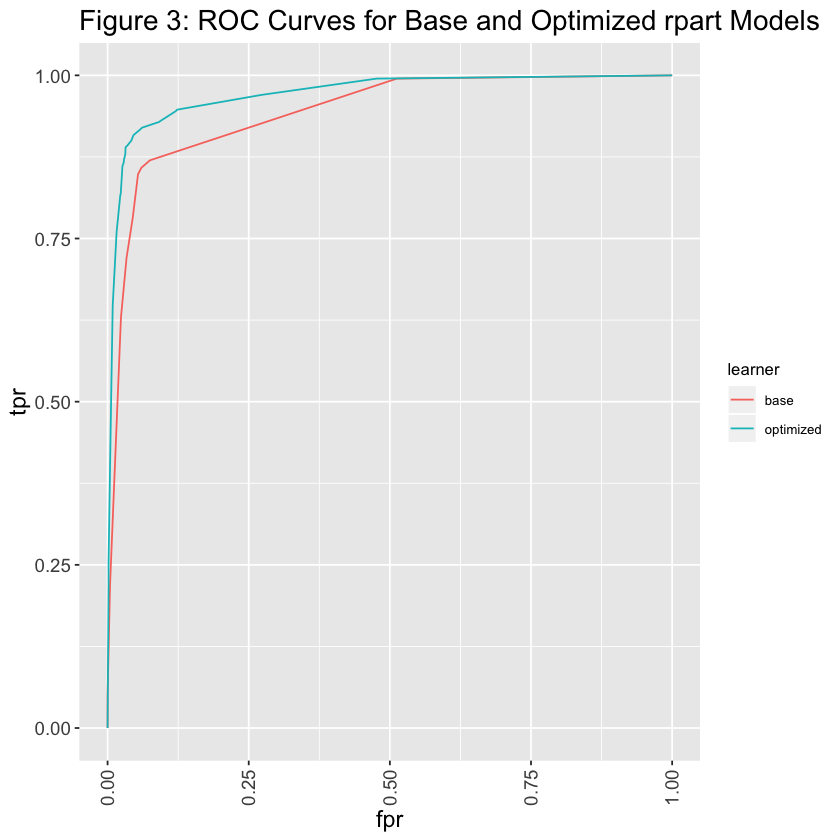

In [48]:
df = generateThreshVsPerfData(list(base = spam.preds, 
                                   optimized = spam.opt.preds), 
                                   measures = list(fpr, tpr))

qplot(x = fpr, y = tpr, color = learner, data = df$data, geom = "path")+
  ggtitle("Figure 3: ROC Curves for Base and Optimized rpart Models")+
  theme(legend.position = "right", 
            legend.text=element_text(size=8),
            legend.title = element_text(size=10),
            axis.text.x = element_text(angle=90, vjust=0.5),
            text=element_text(size=14))

# References

1. Nolan, D., and Temple Lang, D. (2015), *Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving.* Boca Raton, FL: CRC Press (NTL)

2. Package 'rpart', https://cran.r-project.org/web/packages/rpart/rpart.pdf

3. https://www.rdocumentation.org/packages/rpart/versions/4.1-13/topics/rpart.control

# Appendix

## Additional Code

In [23]:
library(mmpf)
library(magrittr)
library(reshape2)
library(plyr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(tm)
library(rpart)
library(caret)
library(mlr)
library(parallelMap)
library(doParallel)
library(missForest)
library(scales)
library(ggthemes)
library(GGally)
library(ltm)
library(rpart.plot)
library(knitr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths

The following object is masked from ‘package:magrittr’:

    extract

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:mlr’:

    train

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘random

In [ ]:
complexityVals = c(seq(0.00001, 0.0001, length=19),
                   seq(0.0001, 0.001, length=19),
                   seq(0.001, 0.005, length=9),
                   seq(0.005, 0.01, length=9))

In [ ]:
fits = lapply(complexityVals, function(x) {
         rpartObj = rpart(isSpam ~ ., data = trainDF,
                          method="class",
                          control = rpart.control(cp=x) )
         predict(rpartObj,
                 newdata = testDF[ , names(testDF) != "isSpam"],
                 type = "class")
})

In [ ]:
spam = testDF$isSpam == "T"
numSpam = sum(spam)
numHam = sum(!spam)
errs = sapply(fits, function(preds) {
                      typeI = sum(preds[ !spam ] == "T") / numHam
                      typeII = sum(preds[ spam ] == "F") / numSpam
                      c(typeI = typeI, typeII = typeII)
})